In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [84]:
READFILE = "havforsk.csv"
FISHFILE = 'hi_arter.txt'
ENCODE = "Windows-1252"

#Import Fish Species into a list for later use, sorting it so longest names appear first
fiske_arter: list[str] = []
with open(FISHFILE, 'r', encoding="UTF-8") as file:
	for line in file:
		fiske_arter.append(line.strip())
fiske_arter.sort(key=len)
fiske_arter = fiske_arter[::-1]

#Function for removing multiple substring from a string
def multi_remove(string, to_remove: list[str]|str) -> str:
	string = string.lower()
	if type(string) != str:
		return string
	for symbol in to_remove:
		string = string.replace(symbol, "")
	return string

ukjente_arter: dict[str:int] = {}

#Function to normalize data, trying to put each validSpecie entry into a known Fish Species
def normalize(string: str) -> str:
	if "(" in string:
		string = string[:string.index("(")]
	string = re.sub("[^ÆØÅæøåa-zA-Z]", "", string).lower()
	string = multi_remove(string, ["vanlig", "usikker", "ukjent", "ikkebilde"])
	
	global fiske_arter
	for art in fiske_arter:
		if art in string:
			return art
	
	global ukjente_arter
	if string in ukjente_arter:
		ukjente_arter[string] = ukjente_arter[string]+1
	else:
		ukjente_arter[string] = 1
	return "annet"



In [85]:
#Create a DataFrame with only the needed columns. 
#Only includes entries where the sighting has been validated
raw_df = pd.read_csv(READFILE, delimiter=";", encoding=ENCODE, engine="python")
df = raw_df[['date', 'isValidated', 'validSpecie']].dropna(axis="index", inplace=False)
print(df)


                            date  isValidated  \
0     "2018-10-23T00:00:00.000Z"         True   
1     "2018-08-17T00:00:00.000Z"         True   
2     "2018-05-26T00:00:00.000Z"         True   
3     "2018-08-29T00:00:00.000Z"         True   
4     "2019-05-22T11:05:32.800Z"         True   
...                          ...          ...   
3367  "2024-09-07T00:00:00.000Z"         True   
3368  "2024-09-08T00:00:00.000Z"         True   
3369  "2024-09-08T00:00:00.000Z"         True   
3370  "2024-09-06T00:00:00.000Z"         True   
3371  "2023-07-31T00:00:00.000Z"         True   

                                       validSpecie  
0                                     Torsk hybrid  
1                                        Død krill  
2                                 Stillehavsøsters  
3                                           Brugde  
4                                         Ubestemt  
...                                            ...  
3367      Amerikansk lobemanet (Mnemiops

In [86]:
#Normalize the validSpecie to minimize spelling errors in dataset and remove unnecessary date information
df['validSpecie'] = df['validSpecie'].map(lambda name : normalize(name))
df['year'] = df['date'].map(lambda date: int(date[1:5]))
df.drop(labels="date", axis=1, inplace=True)
print(df)

      isValidated validSpecie  year
0            True       torsk  2018
1            True       annet  2018
2            True      østers  2018
3            True      brugde  2018
4            True       annet  2019
...           ...         ...   ...
3367         True       manet  2024
3368         True       manet  2024
3369         True  blekksprut  2024
3370         True          al  2024
3371         True       annet  2023

[3372 rows x 3 columns]


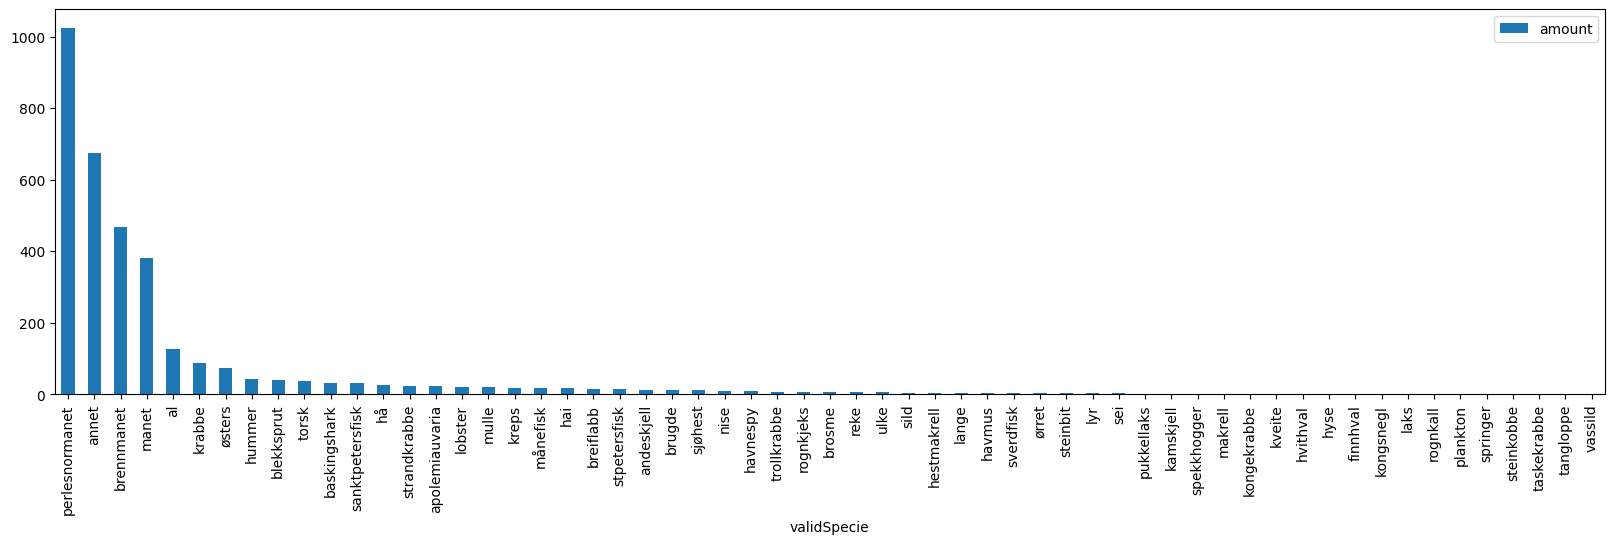

In [87]:
#Group by species and display as a bar graph
species_df = df.groupby(["validSpecie"]).count()
species_df.sort_values(by=['isValidated'], ascending=False,inplace=True)
species_df.rename(columns={"isValidated":"amount"}, inplace=True)
species_df.drop(labels="year", axis=1, inplace=True)
#species_df.reset_index(inplace=True)
#print(species_df)

fig_species, ax_species = plt.subplots(figsize=(20,5))
species_df.plot(kind="bar" ,ax=ax_species)

plt.show()

The plot above shows the count of every unique species found in the dataset, sorted into groups based on a list of species collected from https://www.hi.no/hi/temasider/arter. The list of species was furter supplemented using data from the havforsk.csv dataset.

        validSpecie  year  amount
20            annet  2024     102
48       brennmanet  2024      38
119           manet  2024      25
7                al  2024      21
138  perlesnormanet  2024      21
..              ...   ...     ...
181           torsk  2018       2
26     baskingshark  2018       1
56           brugde  2018       1
197          østers  2018       1
55           brugde  2017       1

[191 rows x 3 columns]


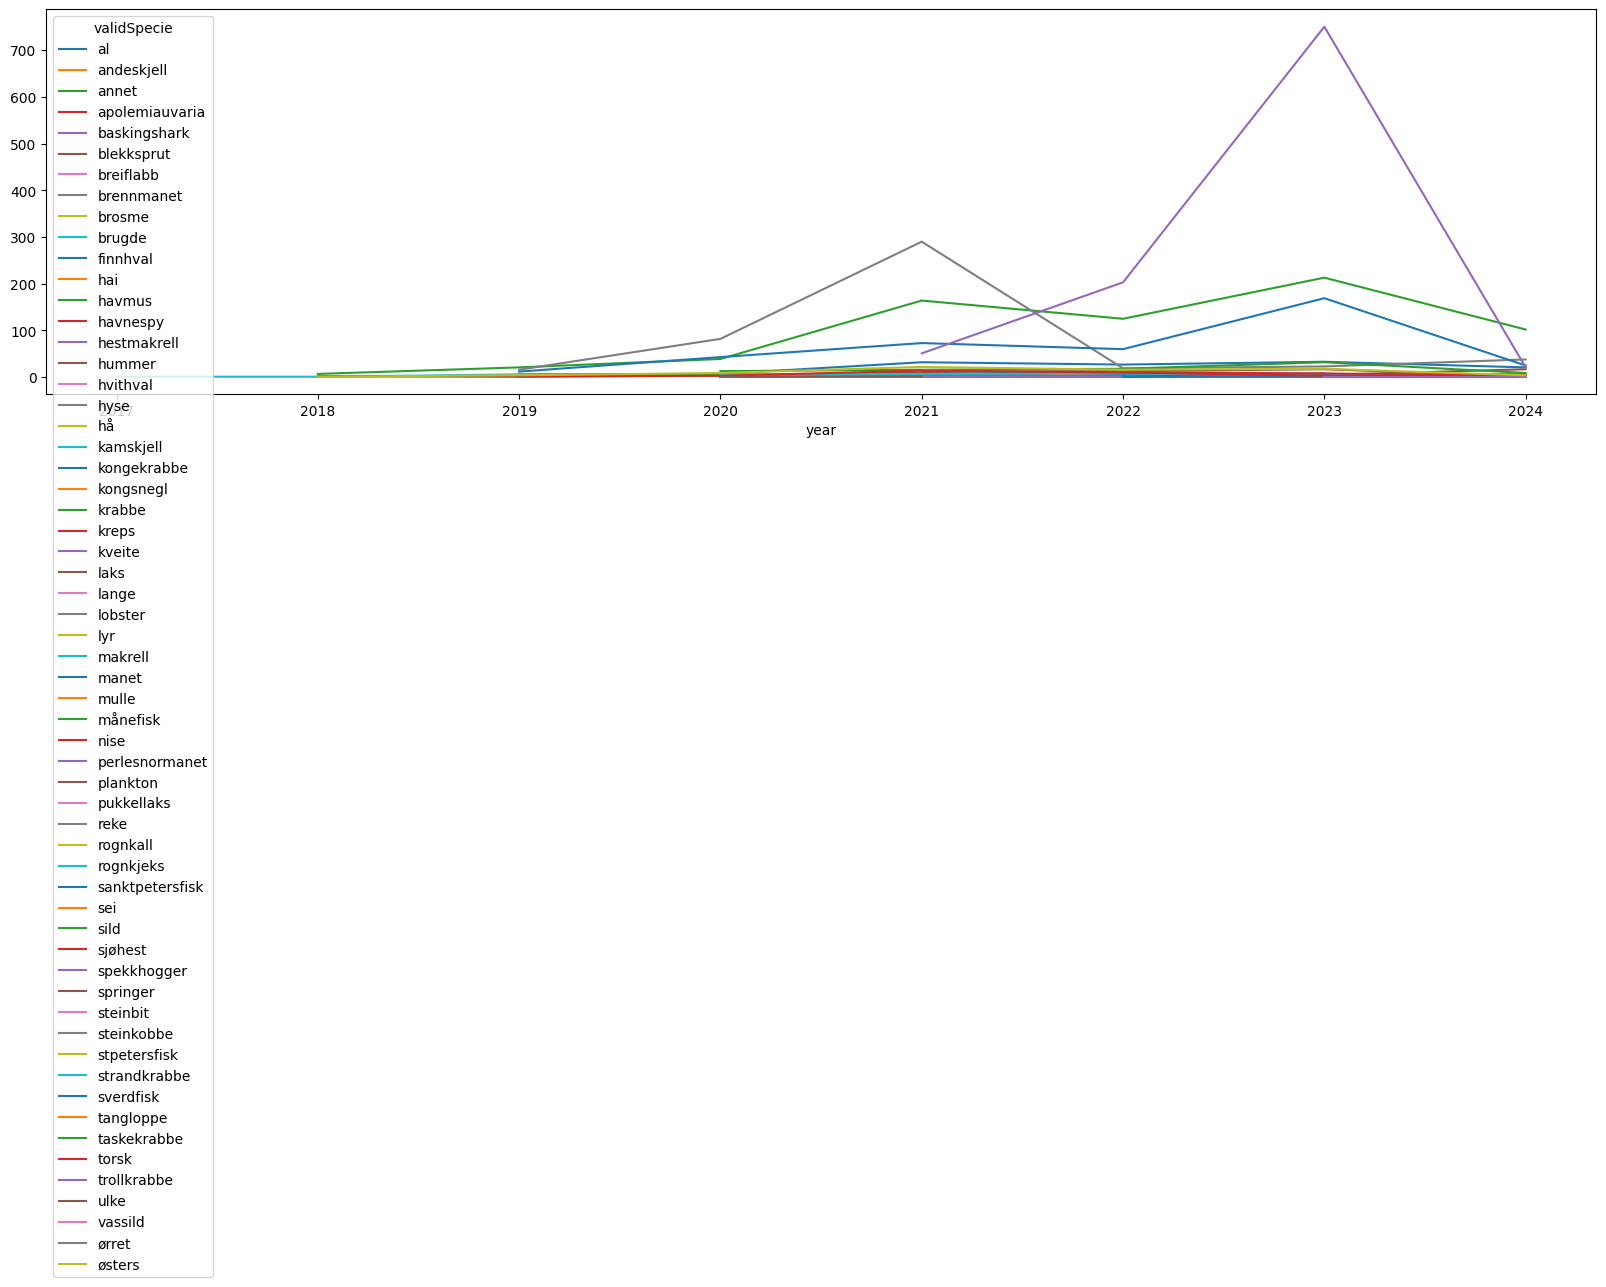

In [88]:
#Group species by year and display as a line graph, ignoring entries before 2017 as they contain very 
# few entries and any conjections made from that data would not be significant.
species_by_year_df = df.groupby(["validSpecie", "year"]).count()
species_by_year_df.reset_index(inplace=True)
species_by_year_df.rename(columns={"isValidated":"amount"}, inplace=True)
species_by_year_df.sort_values(by=['year', 'amount'], inplace=True, ascending=False)

species_by_year_df.drop(species_by_year_df[species_by_year_df.year < 2017].index, inplace=True) #Remove data from before 2017
print(species_by_year_df)

fig_year, ax_year = plt.subplots(figsize=(20,5))
species_by_year_df.pivot_table("amount", index="year", columns=["validSpecie"]).plot(kind="line" ,ax=ax_year)
plt.show()
